# Import

In [1]:
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.73 ms (started: 2022-06-27 15:20:13 +00:00)


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import svm

time: 702 ms (started: 2022-06-27 15:20:13 +00:00)


# Assets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.63 s (started: 2022-06-27 15:20:14 +00:00)


In [4]:
cd drive/MyDrive/Project_DIP/DatasetHandGestures

/content/drive/MyDrive/Project_DIP/DatasetHandGestures
time: 6.48 ms (started: 2022-06-27 15:20:17 +00:00)


In [5]:
directories = os.listdir()
filename = []
label = []

for i in range(0, len(directories)):
  os.chdir(directories[i])
  files = os.listdir()
  for j in range(0, len(files)):
    files[j] = directories[i] + '/' + files[j]
    label.append(directories[i])
  filename = filename + files
  os.chdir("..")
print(filename)
print(label)

['fingerCircle/IMG_20220509_140146.jpg', 'fingerCircle/IMG_20220524_140238.jpg', 'fingerCircle/IMG_20220502_143126.jpg', 'fingerCircle/IMG_20220522_175642.jpg', 'fingerCircle/IMG_20220501_160145.jpg', 'fingerCircle/IMG_20220509_135208.jpg', 'fingerCircle/IMG_20220523_115141.jpg', 'fingerCircle/IMG_20220501_163424.jpg', 'fingerCircle/IMG_20220509_134730.jpg', 'fingerCircle/IMG_20220522_175651.jpg', 'fingerCircle/IMG_20220522_175636.jpg', 'fingerCircle/IMG_20220501_163426.jpg', 'fingerCircle/IMG_20220523_115100.jpg', 'fingerCircle/IMG_20220502_142521.jpg', 'fingerCircle/IMG_20220521_105729.jpg', 'fingerCircle/IMG_20220501_163349.jpg', 'fingerCircle/IMG_20220522_175632.jpg', 'fingerCircle/IMG_20220430_181207.jpg', 'fingerCircle/IMG_20220521_105740.jpg', 'fingerCircle/IMG_20220521_105744.jpg', 'fingerCircle/IMG_20220521_104356.jpg', 'fingerCircle/IMG_20220509_134218.jpg', 'fingerCircle/IMG_20220501_152356.jpg', 'fingerCircle/IMG_20220509_135154.jpg', 'fingerCircle/IMG_20220523_115046.jpg',

In [6]:
data = {"filename" : filename, 
        "label": label 
        }
df = pd.DataFrame(data=data)

df_shuffled = df.sample(frac=1)
dataset = df_shuffled
dataset

,filename,label
1929,singleFingerBend/IMG_20220522_180818.jpg,singleFingerBend
229,fingerCircle/IMG_20220509_134158.jpg,fingerCircle
1294,closedFist/IMG_20220522_141704.jpg,closedFist
1461,openPalm/IMG_20220509_131521.jpg,openPalm
1565,semiOpenPalm/IMG_20220502_131845.jpg,semiOpenPalm
...,...,...
901,fingerSymbols/IMG_20220502_130028.jpg,fingerSymbols
1309,closedFist/IMG_20220521_103931.jpg,closedFist
1571,semiOpenPalm/IMG_20220509_132936.jpg,semiOpenPalm
1159,closedFist/IMG_20220509_133953.jpg,closedFist


time: 31.6 ms (started: 2022-06-27 15:20:17 +00:00)


#Image Preprocessing

In [7]:
# baca data dengan opencv (ditampilkan gambar)

def load_images_files(train_data):
  # definisikan 2 list kosong
  images = []
  Y = []

  for obj in train_data.values:
    # index 0 ([0]) adalah kolom filename, (tidak menggunakan label karena untuk cv2 baca lewat lokasi nya)
    img = cv2.imread(obj[0])
    # smoothing
    img_pred = cv2.GaussianBlur(img, (5, 5), 0)
    # sharpening
    kernel = np.array([[-1,-1,-1], 
                       [-1,9,-1], 
                       [-1,-1,-1]])
    img_pred = cv2.filter2D(img_pred, -1, kernel)
    # resize
    img_pred = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    # ubah rentang pixel yang awalnya 0 - 255 menjadi 0 - 1
    img_pred = img_pred / 255
    # algoritma nearest neighbour bekerja pada 1 dimensi
    # ada 3 perkalian karena gambar berwarna, punya 3 channel rgb
    img_pred = img_pred.reshape(img_pred.shape[0] * img_pred.shape[1] * img_pred.shape[2])
    
    # masukkan ke list images
    images.append(img_pred)
    # tiap row yang ada di Y merepresentasikan label yang ada di images
    Y.append(obj[1])
    
  X = np.array(images)
  Y = np.array(Y)
  
  return X, Y

time: 20.9 ms (started: 2022-06-27 15:20:17 +00:00)


In [8]:
# Split into training and testing data
X, y = load_images_files(dataset)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.3) #test size = 30% untuk testing, 70% untuk training

print("Data shape: ", X.shape)
print(y.shape)
print("X_train: ", X_train.shape) #70% dari data shape
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape) #30% dari data shape
print("y_test: ", y_test.shape)

Data shape:  (2167, 49152)
(2167,)
X_train:  (1516, 49152)
y_train:  (1516,)
X_test:  (651, 49152)
y_test:  (651,)
time: 23.9 s (started: 2022-06-27 15:20:17 +00:00)


# Method

## Gaussian Naive Bayes

In [9]:
# training the model on training set
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# making predictions on the testing set
y_pred = gnb.predict(X_test)

# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
GNBVal = metrics.accuracy_score(y_test, y_pred)*100
print("Gaussian Naive Bayes model accuracy(in %):", GNBVal)
print("")

CM = confusion_matrix(y_pred, y_test)
print("Confusion Matrix")
print(CM)
print("")

Gaussian Naive Bayes model accuracy(in %): 19.508448540706606

Confusion Matrix
[[17  4  5  2  5  9 12  3]
 [ 8 27 12  2  7 20 10 22]
 [ 1  2 12  3  1  4 11  3]
 [10 10 70  9 11 22 29 23]
 [ 7  2 36  0 15  6  1  6]
 [ 6 10  2  3  1 14  9  4]
 [ 9  9 44  0  6 24 28 11]
 [ 0  0  3  0  1  0  3  5]]

time: 5.12 s (started: 2022-06-27 15:20:41 +00:00)


In [10]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))
print("")

Jumlah False Positive = 4
Jumlah False Negative = 8
Jumlah True Positive = 27
Jumlah True Negative = 17

Accuracy : 0.79
Precision : 0.87
Recall : 0.77
F1 Score : 0.41

time: 60.6 ms (started: 2022-06-27 15:20:46 +00:00)


##Random Forest

In [11]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score

rf = ensemble.RandomForestClassifier(n_estimators=500)

# Train the model on training data
rf.fit(X_train, y_train)
# Use the forest's predict method on the test data
y_pred = rf.predict(X_test)
RFVal = accuracy_score(y_test, y_pred)*100
print("Random Forest model accuracy(in %):", RFVal)
print("")

CM = confusion_matrix(y_pred, y_test)
print("Confusion Matrix")
print(CM)
print("")

Random Forest model accuracy(in %): 54.99231950844854

Confusion Matrix
[[ 36   3   3   1   3   4   1   0]
 [  4  39   5   1   3   7   3   1]
 [  3   7 137   8  20  20  30  24]
 [  0   0   0   1   0   0   0   0]
 [  2   1   7   1   2   1   0   0]
 [ 10  12  13   3  10  54  10  11]
 [  1   2  16   3   5   9  56   8]
 [  2   0   3   1   4   4   3  33]]

time: 1min 47s (started: 2022-06-27 15:20:46 +00:00)


In [12]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))
print("")

Jumlah False Positive = 3
Jumlah False Negative = 4
Jumlah True Positive = 39
Jumlah True Negative = 36

Accuracy : 0.91
Precision : 0.93
Recall : 0.91
F1 Score : 0.46

time: 26.7 ms (started: 2022-06-27 15:22:33 +00:00)


##Decision Tree

In [13]:
# Importing the required packages
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):
  
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(
        criterion = "gini", random_state = 100, 
        max_depth = 3, min_samples_leaf = 5)
  
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini
      
# Function to perform training with entropy.
def tarin_using_entropy(X_train, X_test, y_train):
  
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
        criterion = "entropy", random_state = 100,
        max_depth = 3, min_samples_leaf = 5)
  
    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy
  
# Function to make predictions
def DTprediction(X_test, clf_object):
  
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    #print("Predicted values:")
    #print(y_pred)
    return y_pred
      
# Building Phase
clf_gini = train_using_gini(X_train, X_test, y_train)
clf_entropy = tarin_using_entropy(X_train, X_test, y_train)
  
# Prediction using gini
y_pred_gini = DTprediction(X_test, clf_gini)
DTVal =accuracy_score(y_test,y_pred)*100
print("Decision Tree model accuracy(in %):",DTVal)
print("")

CM = confusion_matrix(y_pred, y_test)
print("Confusion Matrix")
print(CM)
print("")

Decision Tree model accuracy(in %): 54.99231950844854

Confusion Matrix
[[ 36   3   3   1   3   4   1   0]
 [  4  39   5   1   3   7   3   1]
 [  3   7 137   8  20  20  30  24]
 [  0   0   0   1   0   0   0   0]
 [  2   1   7   1   2   1   0   0]
 [ 10  12  13   3  10  54  10  11]
 [  1   2  16   3   5   9  56   8]
 [  2   0   3   1   4   4   3  33]]

time: 48.7 s (started: 2022-06-27 15:22:33 +00:00)


In [14]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))
print("")

Jumlah False Positive = 3
Jumlah False Negative = 4
Jumlah True Positive = 39
Jumlah True Negative = 36

Accuracy : 0.91
Precision : 0.93
Recall : 0.91
F1 Score : 0.46

time: 24.2 ms (started: 2022-06-27 15:23:22 +00:00)


##K-Nearest Neighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

KNNVal = 0

for i in range(1, 16):
  knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan')
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  KNNVal = accuracy_score(y_test, y_pred)*100
  print('K=', i, 'Accuracy Score(in %):', KNNVal)

print("")

knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

CM = confusion_matrix(y_pred, y_test)
print("Confusion Matrix")
print(CM)
print("")

K= 1 Accuracy Score(in %): 61.136712749615974
K= 2 Accuracy Score(in %): 51.92012288786483
K= 3 Accuracy Score(in %): 49.615975422427034
K= 4 Accuracy Score(in %): 49.0015360983103
K= 5 Accuracy Score(in %): 47.004608294930875
K= 6 Accuracy Score(in %): 45.314900153609834
K= 7 Accuracy Score(in %): 45.00768049155146
K= 8 Accuracy Score(in %): 43.16436251920123
K= 9 Accuracy Score(in %): 43.31797235023041
K= 10 Accuracy Score(in %): 43.31797235023041
K= 11 Accuracy Score(in %): 42.08909370199693
K= 12 Accuracy Score(in %): 41.474654377880185
K= 13 Accuracy Score(in %): 41.474654377880185
K= 14 Accuracy Score(in %): 41.013824884792626
K= 15 Accuracy Score(in %): 40.39938556067588

Confusion Matrix
[[ 35   1   8   1   6  12   4   2]
 [  2  52   2   2   0   1   1   1]
 [  0   3 105   1  10   7   9   9]
 [  0   1   6   2   0   2   3   3]
 [  3   0   8   0  17   4   1   2]
 [ 15   3  15   3   5  60   7   3]
 [  2   2  28   2   4   8  75   5]
 [  1   2  12   8   5   5   3  52]]

time: 13min 4

In [16]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))
print("")

Jumlah False Positive = 1
Jumlah False Negative = 2
Jumlah True Positive = 52
Jumlah True Negative = 35

Accuracy : 0.97
Precision : 0.98
Recall : 0.96
F1 Score : 0.49

time: 15.3 ms (started: 2022-06-27 15:37:07 +00:00)


##SVM

In [17]:
#Classify the image using SVM Classifier
from sklearn import svm
#Createasvm Classifier
clf=svm.SVC(kernel='poly')#Linear Kernel
#Train the model using the training sets
clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred=clf.predict(X_test)

SVMVal = accuracy_score(y_test,y_pred)*100
print("Accuracy Score (in %):", SVMVal)
print("")

CM = confusion_matrix(y_pred, y_test)
print("Confusion Matrix")
print(CM)
print("")

Accuracy Score (in %): 44.70046082949309

Confusion Matrix
[[ 35  10   8   3   3  17   5   4]
 [  4  37   9   4   5  12   6   7]
 [  3   7 100   1  11  15  26  15]
 [  0   0   4   1   1   2   0   1]
 [  2   1  12   3  14   9   3   8]
 [  6   6  19   2   7  33  10  11]
 [  4   3  19   3   0   8  46   6]
 [  4   0  13   2   6   3   7  25]]

time: 2min 40s (started: 2022-06-27 15:37:07 +00:00)


In [18]:
FP = CM[0][1] 
FN = CM[1][0]
TP = CM[1][1]
TN = CM[0][0]
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
# Precision
PR = (TP)/(TP+FP)
# Recall
RE = (TP)/(TP+FN)
# F1 Score
F1 = (PR*RE)/(PR+RE)

print("Jumlah False Positive = " + str(FP))
print("Jumlah False Negative = " + str(FN))
print("Jumlah True Positive = " + str(TP))
print("Jumlah True Negative = " + str(TN))
print("")
print("Accuracy : " + str(round(ACC,2)))
print("Precision : " + str(round(PR,2)))
print("Recall : " + str(round(RE,2)))
print("F1 Score : " + str(round(F1,2)))
print("")

Jumlah False Positive = 10
Jumlah False Negative = 4
Jumlah True Positive = 37
Jumlah True Negative = 35

Accuracy : 0.84
Precision : 0.79
Recall : 0.9
F1 Score : 0.42

time: 26 ms (started: 2022-06-27 15:39:47 +00:00)


##K-Fold Cross Validation


#### Gaussian Naive Bayes

In [19]:
gnb = GaussianNB()
gnb_cvs=cross_val_score(gnb, X, y, cv=5).mean()
print(gnb_cvs)
print("")

0.196591138876768

time: 12.1 s (started: 2022-06-27 15:39:47 +00:00)


#### Random Forest

In [20]:
rf=ensemble.RandomForestClassifier(n_estimators=500)
rf_cvs=cross_val_score(rf, X, y, cv=5).mean()
print(rf_cvs)
print("")

0.5597588361128553

time: 9min 58s (started: 2022-06-27 15:40:00 +00:00)


#### Decision Tree

In [21]:
dt = tree.DecisionTreeClassifier(max_depth=3)
dt_cvs = cross_val_score(dt, X, y, cv=5).mean()
print(dt_cvs)
print("")

0.26395100094720153

time: 1min 34s (started: 2022-06-27 15:49:58 +00:00)


#### K-Nearest Neighbors

In [22]:
#knn = KNeighborsClassifier(n_neighbors=1,metric='euclidean') # 0.5902065750683795
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan') # 0.6155873181426337
#knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski') # 0.5902065750683795
#knn = KNeighborsClassifier(n_neighbors=1, metric='chebyshev') # 0.2381126211938996
knn_cvs = cross_val_score(knn, X, y, cv=5).mean()
print(knn_cvs)
print("")

0.6155905109566736

time: 3min 11s (started: 2022-06-27 15:51:33 +00:00)


#### SVM

In [23]:
svm_val = svm.SVC(kernel='poly') # 0.465162141739658
#svm_val = svm.SVC(kernel='linear') # 0.4125647875182256
#svm_val = svm.SVC(kernel='sigmoid') # 0.24411724013154396
#svm_val = svm.SVC(kernel='rbf') # 0.4564010600142613
svm_cvs=cross_val_score(svm_val, X, y, cv=5).mean()
print(svm_cvs)
print("")

0.45962367365183426

time: 16min 1s (started: 2022-06-27 15:54:44 +00:00)


### Graph

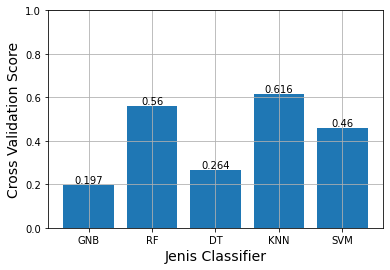

time: 228 ms (started: 2022-06-27 16:10:45 +00:00)


In [24]:
import matplotlib.pyplot as plt

# labels for bars
x = ['GNB', 'RF', 'DT', 'KNN', 'SVM']

# heights of bars
y = [round(gnb_cvs, 3), round(rf_cvs, 3), round(dt_cvs, 3), round(knn_cvs, 3), round(svm_cvs, 3)]
 
# plotting a bar chart
plt.bar(x, y)

# add value labels
for i in range(len(x)):
  plt.text(i, y[i], y[i], ha="center", va="bottom")

# plot title
# plt.title('Perbandingan Cross Validation Score untuk tiap jenis Classifier', fontsize=14)
# naming the x-axis
plt.xlabel('Jenis Classifier', fontsize=14)
# naming the y-axis
plt.ylabel('Cross Validation Score', fontsize=14)

plt.ylim(0,1)

plt.grid(True)
# function to show the plot
plt.show()

#Testing

In [25]:
def load_single_image_files(path):
    images = []
    img = cv2.imread(path)
    # smoothing
    img_pred = cv2.GaussianBlur(img, (5, 5), 0)
    # sharpening
    kernel = np.array([[-1,-1,-1], 
                       [-1,9,-1], 
                       [-1,-1,-1]])
    img_pred = cv2.filter2D(img_pred, -1, kernel)
    # resize
    img_pred = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    # ubah rentang pixel yang awalnya 0 - 255 menjadi 0 - 1
    img_pred = img_pred / 255
    # algoritma nearest neighbour bekerja pada 1 dimensi
    # ada 3 perkalian karena gambar berwarna, punya 3 channel rgb
    img_pred = img_pred.reshape(img_pred.shape[0] * img_pred.shape[1] * img_pred.shape[2])
    
    # masukkan ke list images
    images.append(img_pred)
    
    X = np.array(images)
    return X

time: 24 ms (started: 2022-06-27 16:10:45 +00:00)


Saving IMG_20220430_183637.jpg to IMG_20220430_183637.jpg

Prediksi menggunakan Gaussian Naive Bayes
['semiOpenPalm']

Prediksi menggunakan Random Forest
['fingerCircle']

Prediksi menggunakan DT (Decission Tree) Classifier
['singleFingerBend']

Prediksi menggunakan K-Nearest Neighbor
['fingerCircle']

Prediksi menggunakan SVM (Support Vector Machine) Classifier
['fingerCircle']



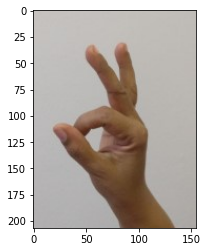

time: 1min 47s (started: 2022-06-27 16:16:49 +00:00)


In [28]:
from matplotlib import image
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  #Predicting images
  path = fn

  X_single = load_single_image_files(path)

  img =  cv2.imread(path)
  imgshow = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  imgplot = plt.imshow(imgshow)

  print("")

  gnb.fit(X_train, y_train)
  nb_pred_single = gnb.predict(X_single)
  print("Prediksi menggunakan Gaussian Naive Bayes")
  print(nb_pred_single)

  print("")

  rf.fit(X_train, y_train)
  rf_pred_single = rf.predict(X_single)
  print("Prediksi menggunakan Random Forest")
  print(rf_pred_single)

  print("")
  
  dt_pred_single = DTprediction(X_single, clf_gini)
  print("Prediksi menggunakan DT (Decission Tree) Classifier")
  print(dt_pred_single)

  print("")

  knn.fit(X_train, y_train)
  knn_pred_single = knn.predict(X_single)
  print("Prediksi menggunakan K-Nearest Neighbor")
  print(knn_pred_single)

  print("")

  svm_pred_single = clf.predict(X_single)
  print("Prediksi menggunakan SVM (Support Vector Machine) Classifier")
  print(svm_pred_single)

  print("")